![Alt text](data/dropkick_logo.png)

# Manual Filtering Example

The purpose of this notebook is to describe the manually-curated cell filtering labels used in the `dropkick` manuscript as a comparison to final labels from the trained model on 33 inDrop single-cell RNA-sequencing (scRNA-seq) datasets.

This approach uses dimension-reduced clustering and gating to remove low-quality cells from a lightly-filtered dataset based on global heuristics such as total counts, total genes, percent mitochondrial counts, and percent ambient counts per barcode.

---

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as stats
import scanpy as sc; sc.set_figure_params(dpi=200); sc.settings.verbosity = 3
import manualfilter as qc  # import useful convenience functions

In [2]:
data = sc.read("data/3907_S1.h5ad")

In [3]:
data = qc.reorder_AnnData(data, descending=True)
data.raw = data

Calculating QC Metrics
Inflection point at [ 4799  7945 11091] for [0, 15, 30] percentiles of greatest secant distances


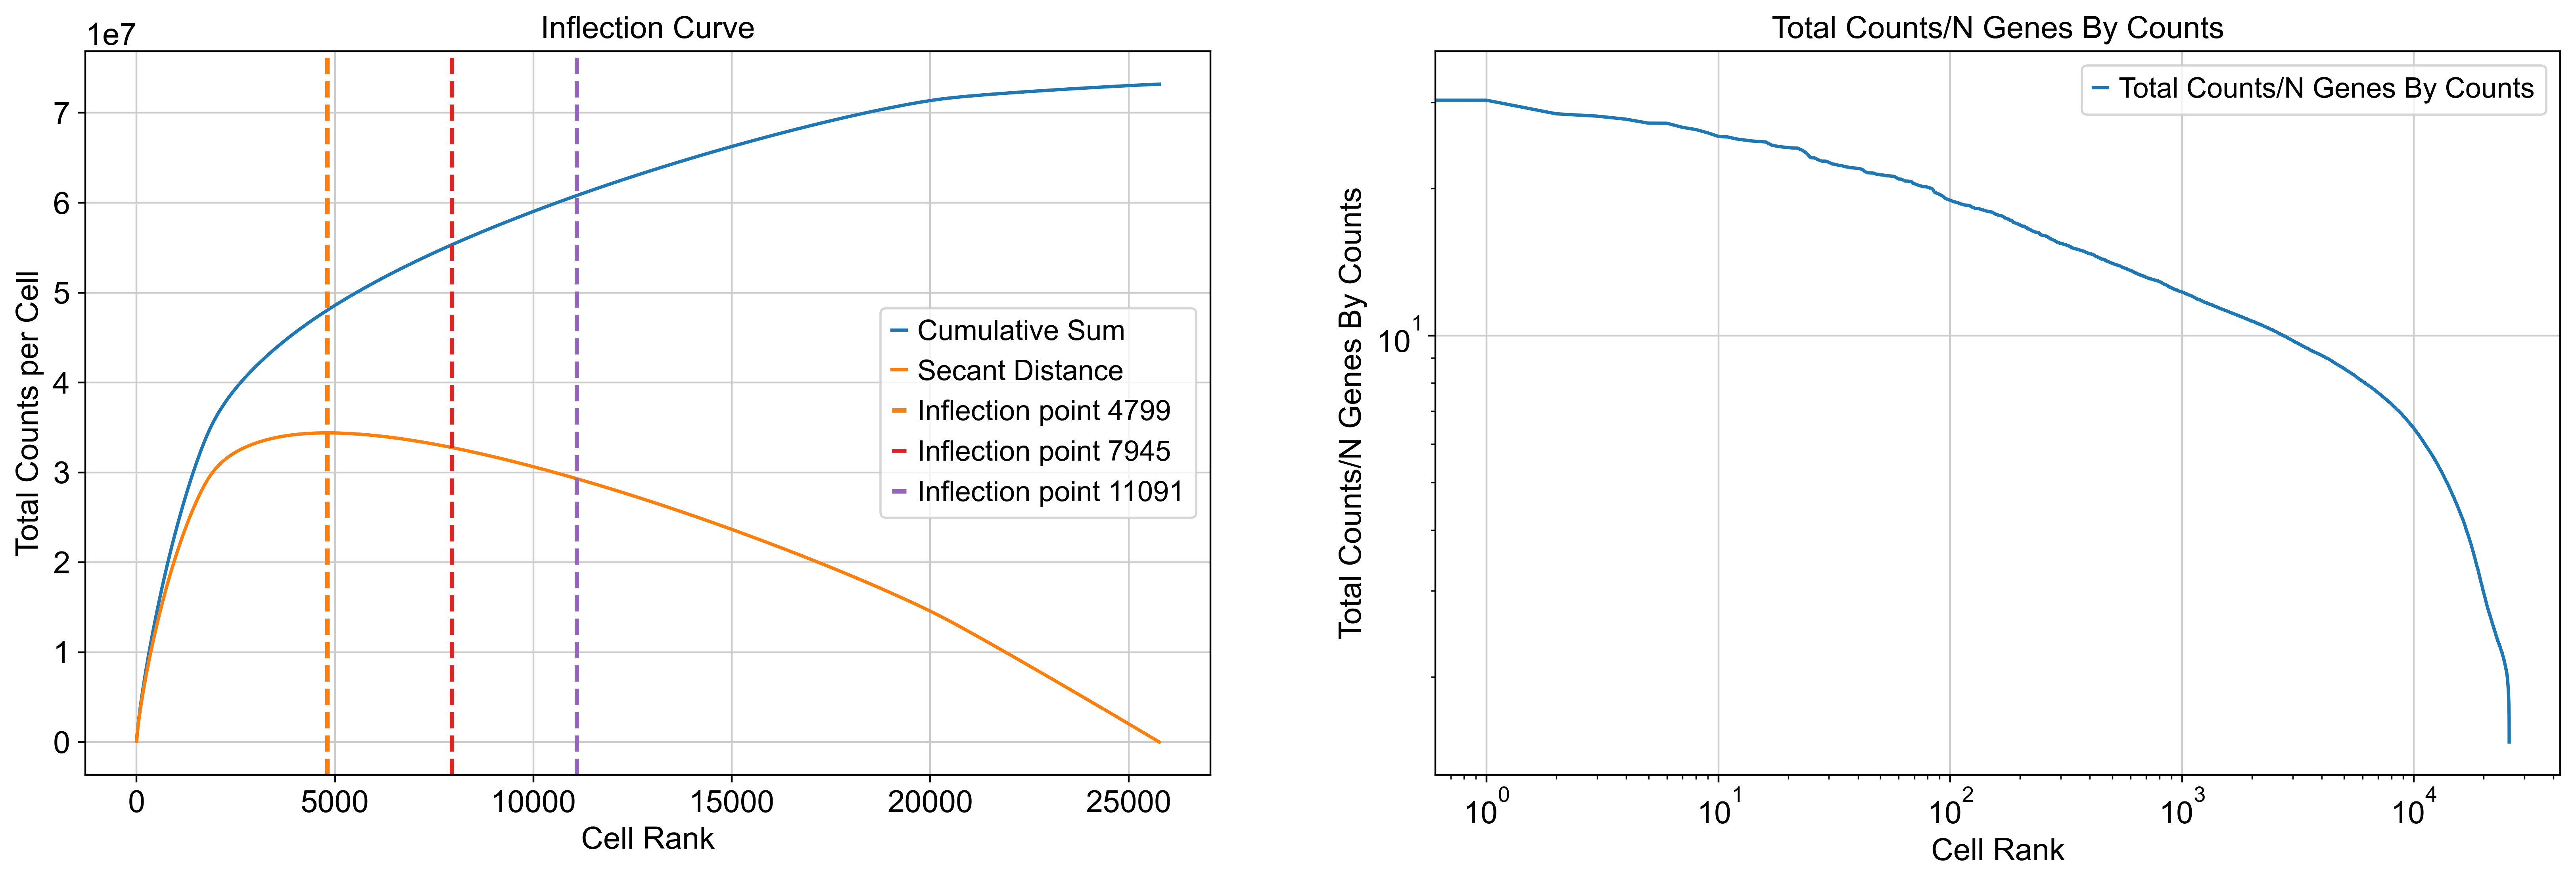

In [4]:
inf = qc.find_inflection(data)

In [5]:
sc.pp.filter_cells(data,min_counts=data[inf[0]].obs.total_counts[0])

filtered out 20973 cells that have less than 2839 counts


In [6]:
sc.pp.normalize_total(data)

normalizing counts per cell
    finished (0:00:00)


In [7]:
data.X = np.arcsinh(data.X).copy()

In [8]:
sc.pp.scale(data)

In [9]:
sc.pp.pca(data)

computing PCA with n_comps = 50
    finished (0:00:10)


In [10]:
sc.pp.neighbors(data, n_neighbors=np.sqrt(data.n_obs).astype(int))  # use sqrt number of obs for optimal k in kNN graph

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)


In [11]:
sc.tl.leiden(data)  # graph-based clustering

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [12]:
sc.tl.umap(data)  # generate UMAP embedding

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


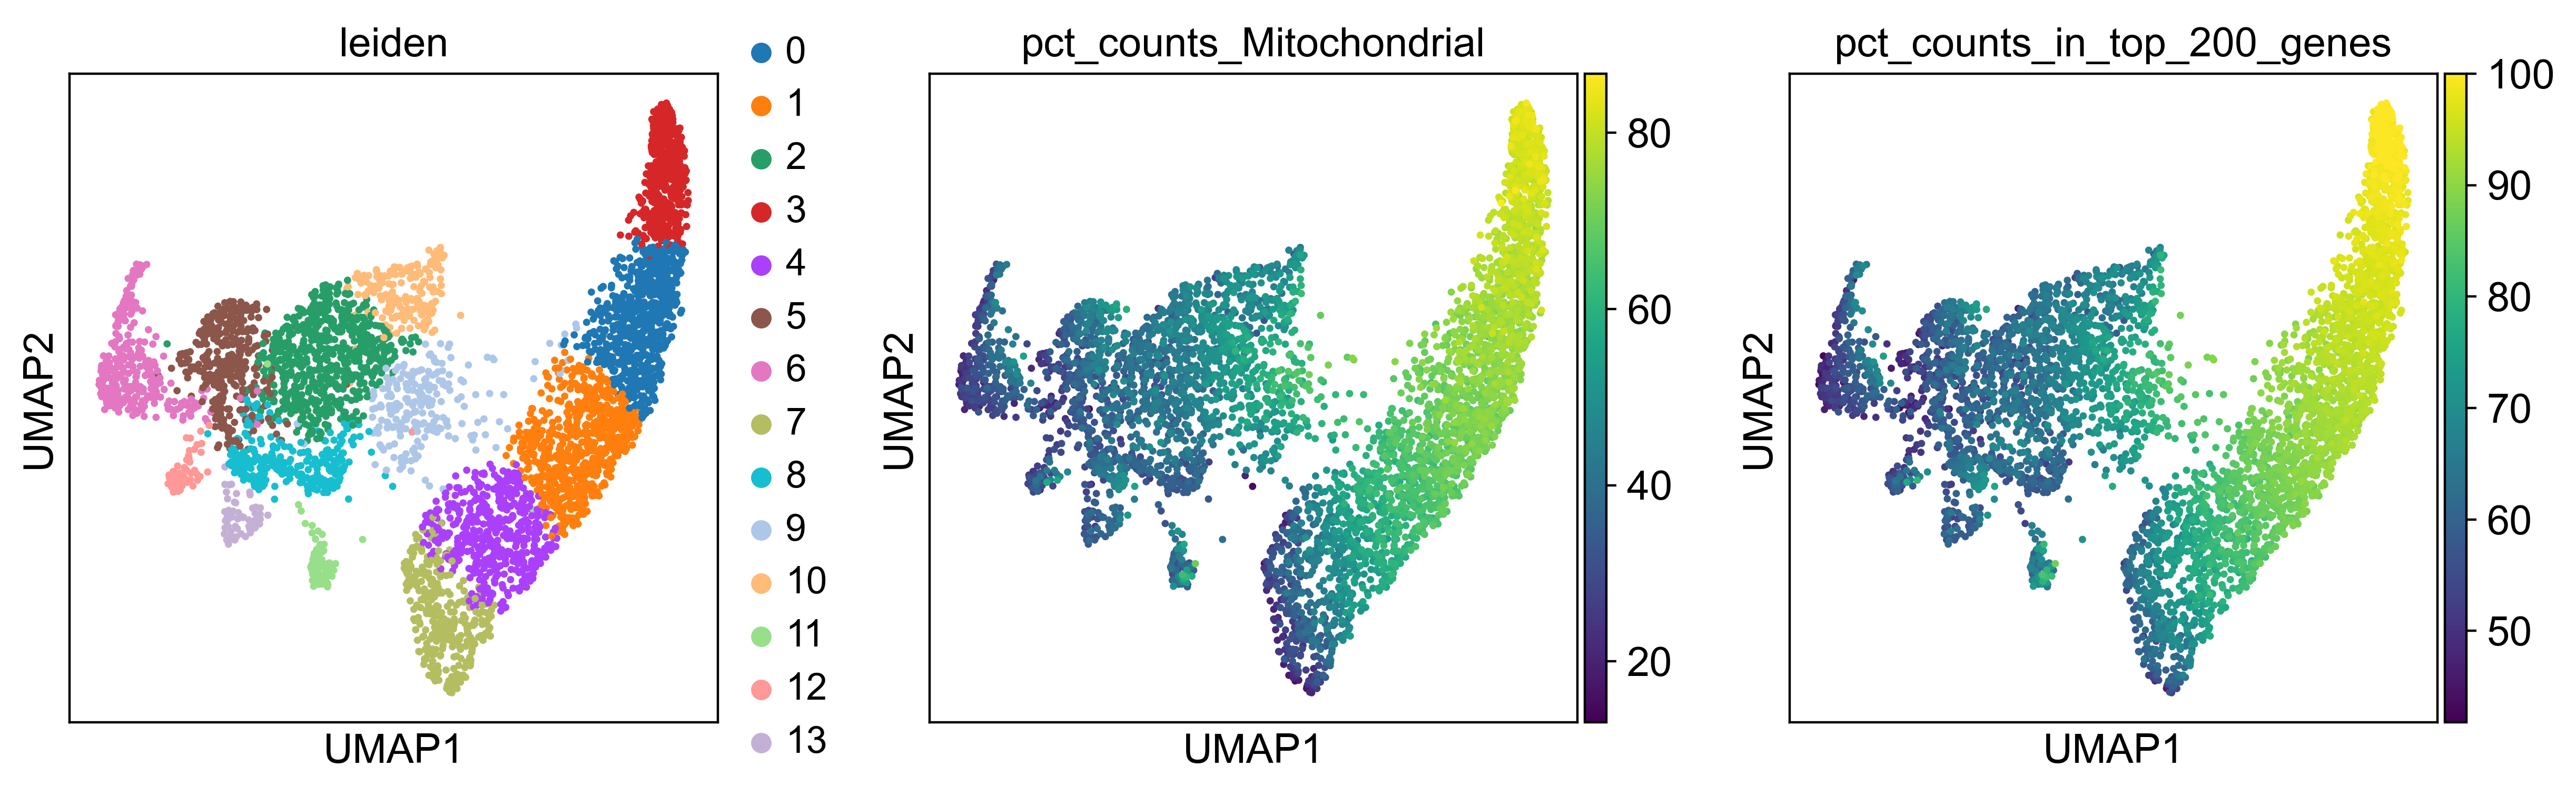

In [13]:
sc.pl.umap(data, color=["leiden","pct_counts_Mitochondrial","pct_counts_in_top_200_genes"])

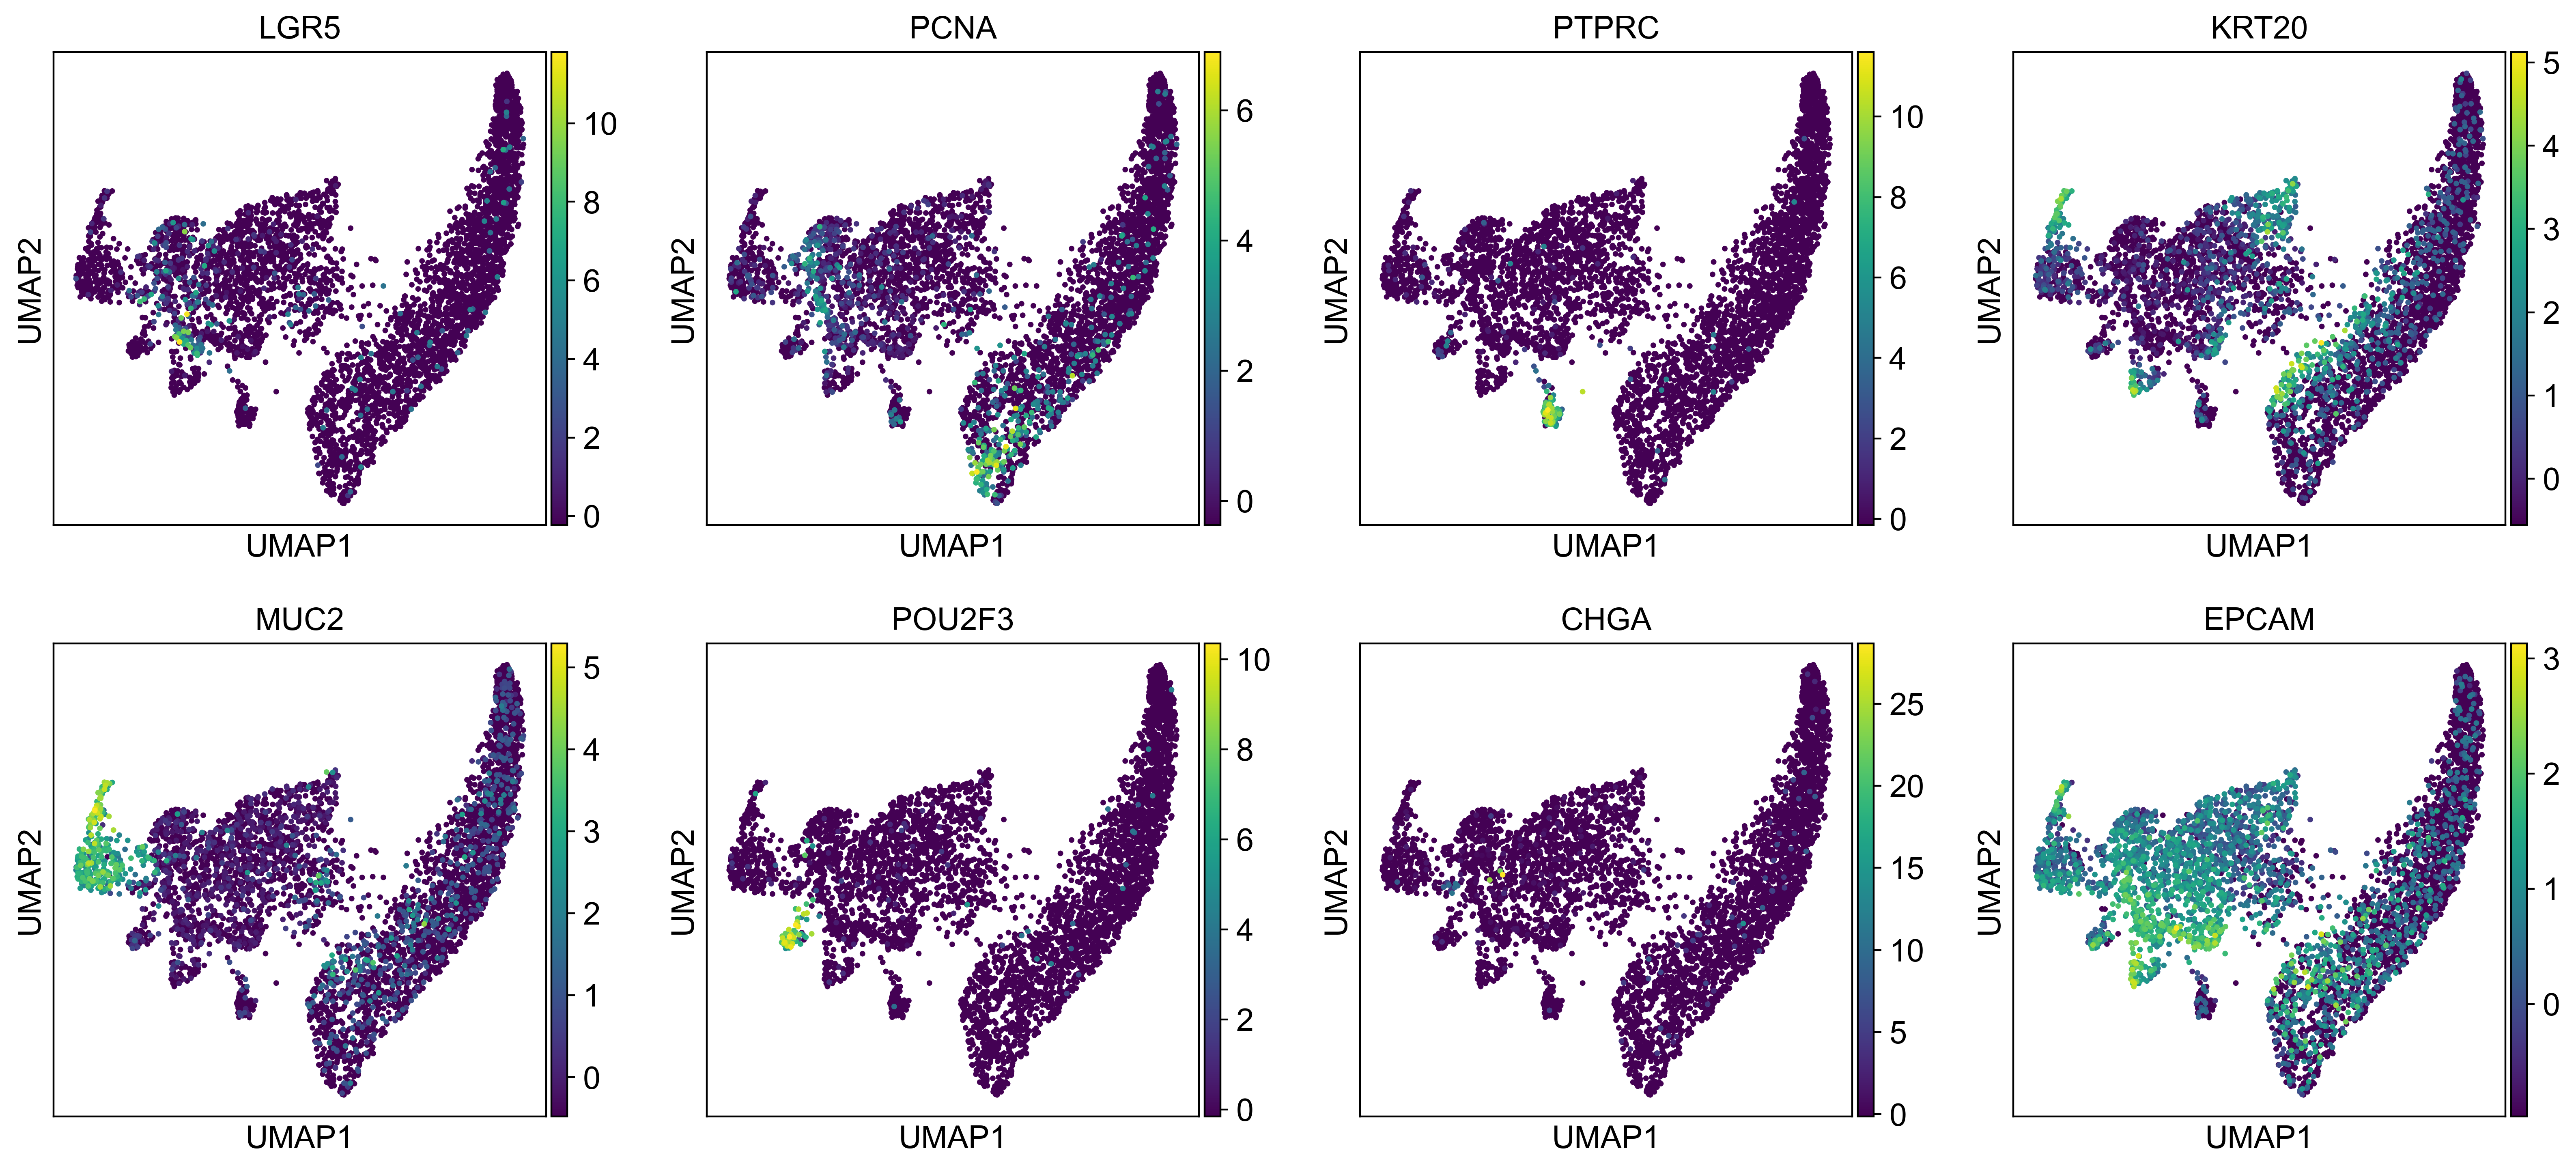

In [14]:
sc.pl.umap(data, color=["LGR5","PCNA","PTPRC","KRT20","MUC2","POU2F3","CHGA","EPCAM"], use_raw=False)

We see high mitochondrial enrichment and sporadic expression of marker genes in the large group of clusters. We will gate these out by selecting the other clusters - containing "real cells" - to keep.

In [15]:
selected_clusters = ["2","5","6","8","9","10","11","12","13"]

In [16]:
data.obs["Cell_Selection"] = np.isin(data.obs["leiden"], selected_clusters).astype(bool)

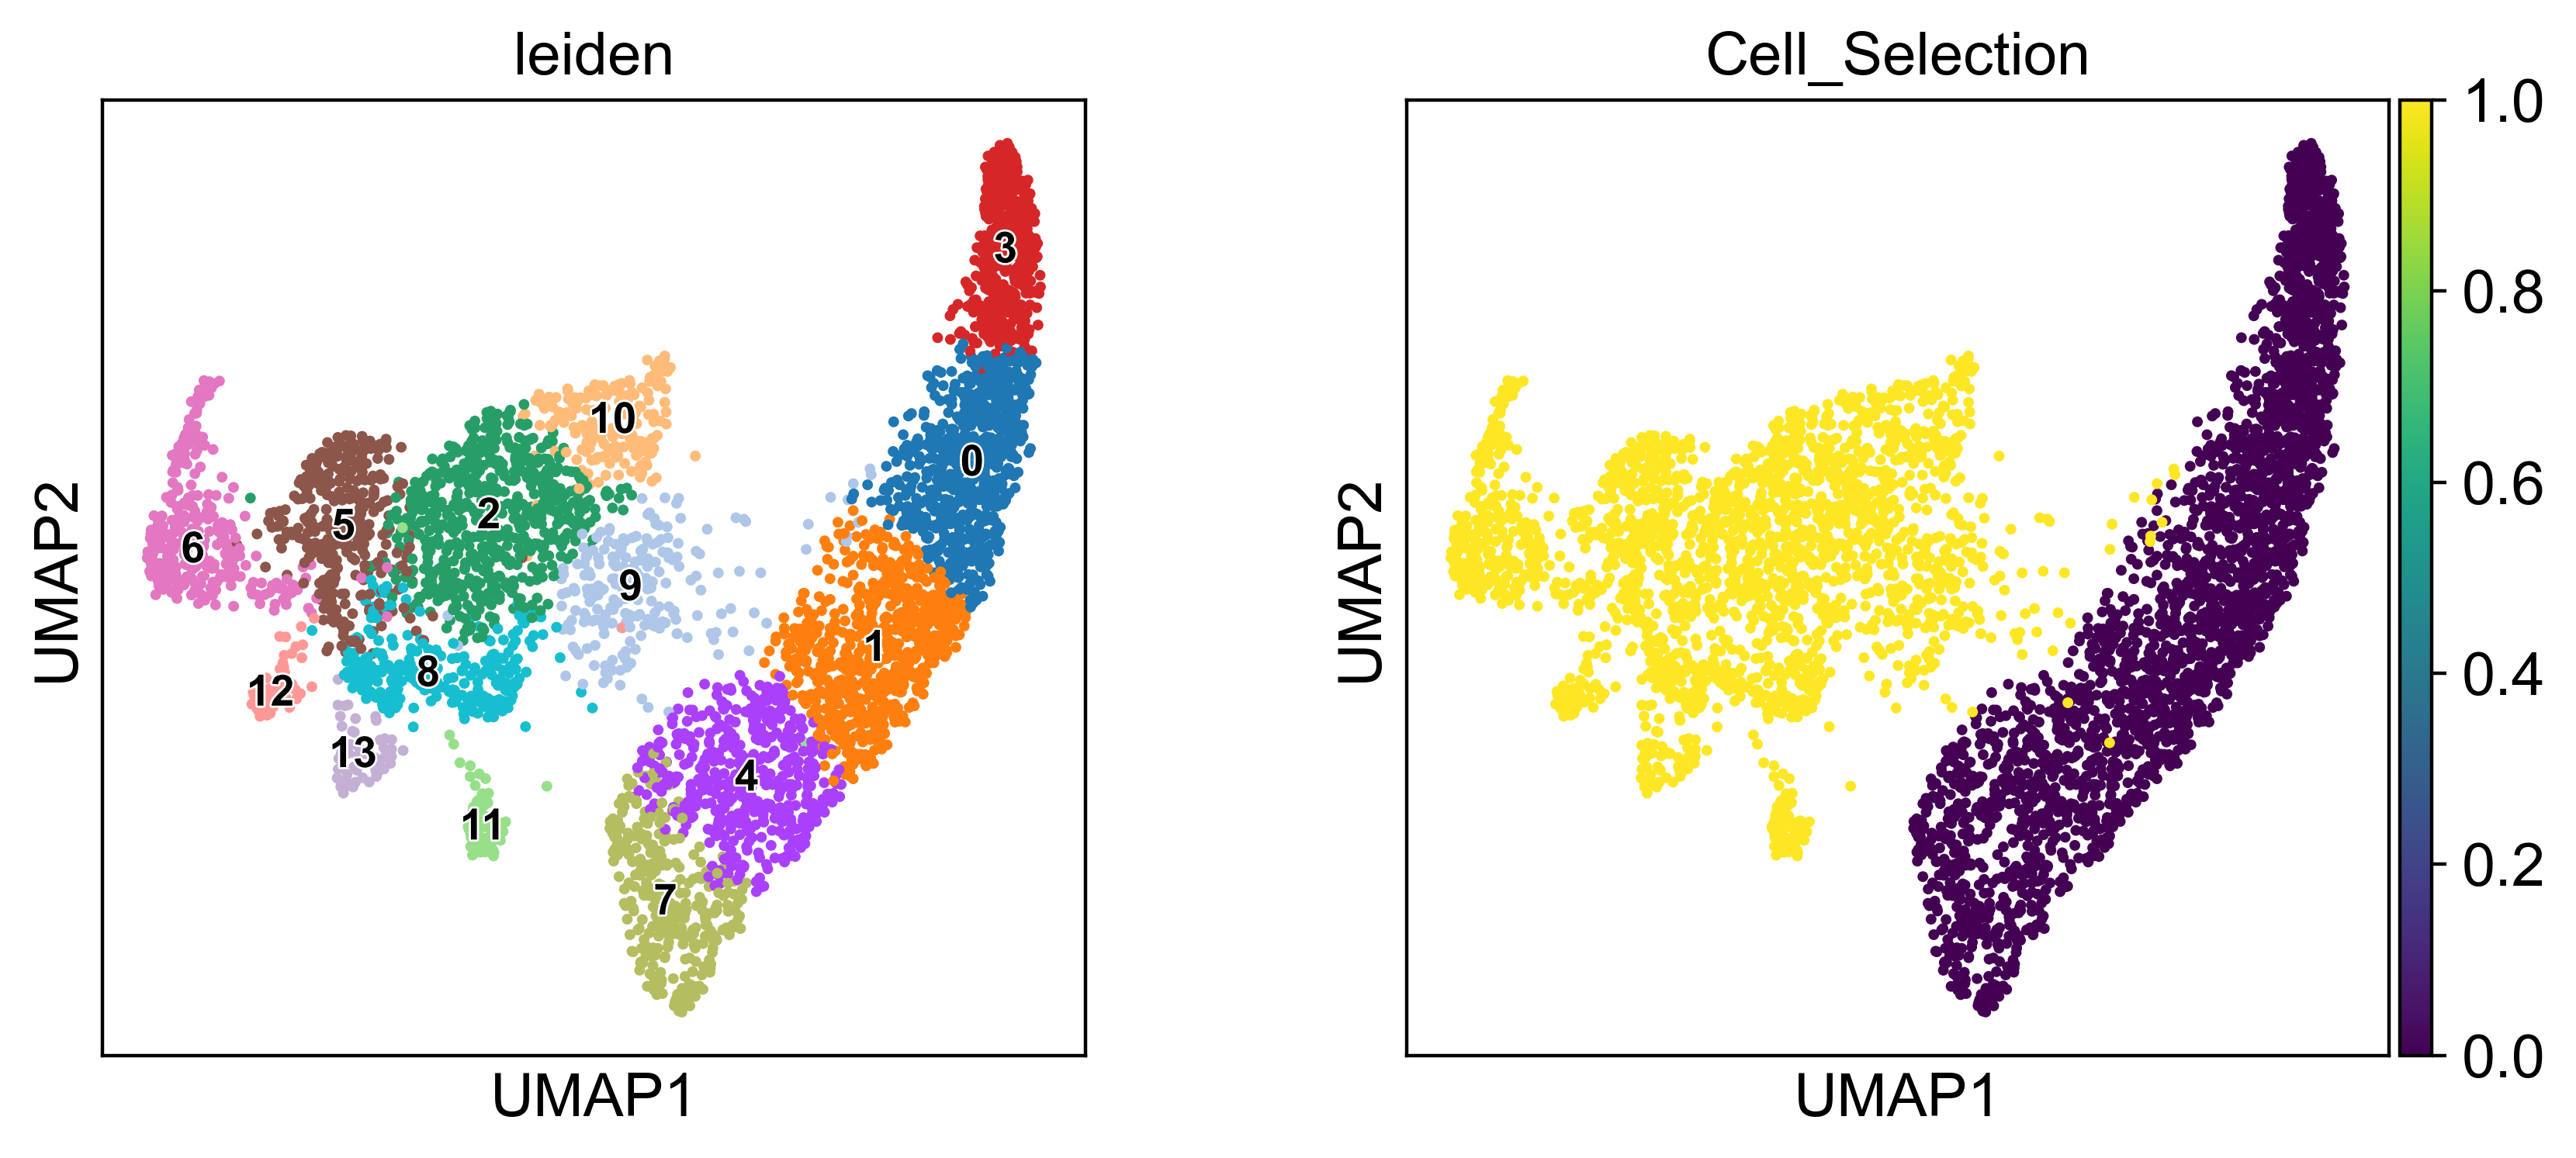

In [17]:
sc.pl.umap(data, color=["leiden","Cell_Selection"], legend_loc="on data", legend_fontoutline=True, legend_fontsize=10)

In [18]:
data.obs.Cell_Selection.value_counts()

False    2583
True     2218
Name: Cell_Selection, dtype: int64

In [19]:
data_out = qc.subset_cleanup(data)

In [20]:
data_out

AnnData object with n_obs × n_vars = 2218 × 29318 

In [21]:
data_out.write_h5ad("data/3907_S1_manualfilter.h5ad", compression="gzip")